# Configuration Section - Important

In [1]:
colab_flag = False  # Set it true if the notebook is run on Colab
language_model ="fin_lab_large"  # imdb | abc | fin_unlab | fin_lab_balance | fin_lab_large | fin_lab_imp2
set_labels = "large"  # bal | large | imp2


# Importing Modules

## General Libraries

In [2]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

## For Colab

In [3]:
if colab_flag:
  
  !pip install -Uqq fastbook   
  from fastbook import * 
  from google.colab import drive 
  drive.mount('/content/drive')
  %cd /content/drive/My\ Drive/Colab\ Notebooks/

  root = "/content/drive/My Drive/Colab Notebooks/"

  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)

else:

  root = "C:/Users/user/ML/Ironhack/GitHub/Final_Project/"

## Deep Learning

In [4]:
from fastai.text.all import *

# Loading Data

In [5]:
with open(f"Data/dls/dls_lm_{language_model}", "rb") as f:
    
    dls_lm = pickle.load(f)

    f.close()

    encoder = f"{language_model}_encoder"


# Building the LSTM classification model with a transfer learning approach

#Fine tuning the classifier model

### Creating the Classifier DataLoaders

In [6]:
path = Path(root + f"Data/financial/labelled/{set_labels}")

In [7]:
dls_clas = DataBlock(
                     blocks=(TextBlock.from_folder(path, vocab=dls_lm.vocab),CategoryBlock),
                     get_y = parent_label,
                     get_items=partial(get_text_files, folders=['train', 'test']),
                     splitter=GrandparentSplitter(valid_name='test')
                     ).dataloaders(path, path=path, bs=50, seq_len=72)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [8]:
# Saving the classification dls

with open(f"Data/dls/dls_clas_{set_labels}", "wb") as f:

    pickle.dump(dls_clas, f)

    f.close()

In [9]:
dls_clas.show_batch(max_n=5)

,text,category
0,"xxbos xxup st . xxup petersburg , xxmaj oct 14 ( xxup prime - xxunk ) -- xxmaj finnish xxunk producer xxmaj nokian xxmaj tyres plans to invest about 50 million euros in the expansion of its xxunk plant in the city of xxmaj xxunk in xxmaj russia 's xxmaj xxunk xxmaj region in 2011 , the company 's xxmaj president xxmaj xxunk xxmaj xxunk told xxunk xxmaj thursday .",positive
1,"xxbos xxunk to xxup eur2 .8 m 9 - xxunk ' 09 29 xxmaj october 2009 - xxmaj finnish software and hardware developer xxmaj elektrobit xxmaj oyj xxup hel : xxup xxunk , or xxup eb , said today that its net loss narrowed to xxup eur2 .8 m for the first nine months of 2009 from xxup xxunk .6 m for the same period a year ago .",positive
2,"xxbos xxup kauko - telko xxup ltd xxup press xxup release xxunk xxup at xxunk 1 ( 1 ) xxmaj telko xxmaj group ( kauko - telko ) is expanding its strategic partnership with xxup bp xxmaj industrial xxmaj xxunk & xxmaj services ( xxup bp xxup xxunk ) by acquiring total xxunk of xxup bp 's xxmaj swedish retail company , xxunk - xxunk xxup ab .",positive
3,"xxbos xxup xxunk , xxrep 3 0 in xxup q1 2010 6 xxmaj may 2010 - xxmaj finnish textile and clothing design company xxmaj marimekko xxmaj oyj ( xxup hel : xxup mmo1v ) said today its net profit rose to xxup xxunk , xxrep 3 0 in the first quarter of 2010 from xxup eur13 , xxrep 3 0 in the corresponding period a year earlier .",positive
4,"xxbos xxmaj finnish silicon wafers manufacturer xxmaj okmetic xxmaj oyj said on xxmaj june 29 , 2007 it signed an agreement with xxmaj nordea xxmaj bank xxmaj finland xxmaj plc , the local subsidiary of xxmaj swedish commercial bank xxmaj nordea xxmaj bank xxup ab , which will xxunk xxmaj okmetic 's syndicated bank facility which xxunk to some 20 mln euro ( $ xxunk mln ) .",positive


### Creating the classifier model

In [31]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

C:\Users\user\miniconda3\envs\DA_ENV\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [32]:
# Let us load the encoder
learn.load_encoder(encoder)

### Fine-Tuning the Classifier

In [33]:
learn.fit_one_cycle(1, 2e-2)

C:\Users\user\miniconda3\envs\DA_ENV\lib\site-packages\torch\cuda\amp\grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,0.569479,0.501511,0.745501,00:29


In [34]:
# Let us progressively unfrezze the model. First the last two layers.
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

C:\Users\user\miniconda3\envs\DA_ENV\lib\site-packages\torch\cuda\amp\grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,0.500051,0.464973,0.766067,00:33


In [35]:
# A bit more
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

C:\Users\user\miniconda3\envs\DA_ENV\lib\site-packages\torch\cuda\amp\grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,0.411197,0.390902,0.825193,00:54


In [36]:
# And the whole model
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3))

C:\Users\user\miniconda3\envs\DA_ENV\lib\site-packages\torch\cuda\amp\grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,0.322508,0.416000,0.817481,01:16
1,0.285051,0.331201,0.861183,01:16
2,0.240498,0.296076,0.892031,01:15
3,0.204673,0.296773,0.894602,01:16
4,0.176812,0.288600,0.907455,01:17


### Exporting the model

In [37]:
learn.save(f"{language_model}_{set_labels}_inferer")

Path('C:/Users/user/ML/Ironhack/GitHub/Final_Project/Data/financial/labelled/large/models/fin_lab_large_large_inferer.pth')

# Interpreting the results

In [38]:
interp = ClassificationInterpretation.from_learner(learn)

C:\Users\user\miniconda3\envs\DA_ENV\lib\site-packages\torch\cuda\amp\grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


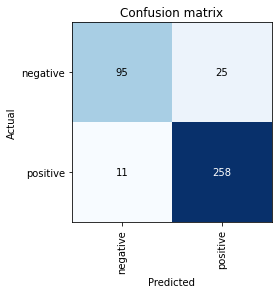

In [39]:
interp.plot_confusion_matrix()

In [40]:
learn.show_results()

C:\Users\user\miniconda3\envs\DA_ENV\lib\site-packages\torch\cuda\amp\grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


,text,category,category_
0,xxbos 8 xxmaj may 2009 - xxmaj finnish liquid handling products and diagnostic test systems maker xxmaj biohit xxmaj oyj ( xxup hel : xxup xxunk ) said today ( 8 xxmaj may 2009 ) its net loss narrowed to xxup eur0 .1 m ( xxup xxunk xxunk m ) for the first quarter of 2009 from xxup eur0 .4 m for the same period of 2008 .,positive,positive
1,"xxbos xxmaj xxunk xxmaj third xxmaj xxunk xxmaj logistics xxmaj leader xxmaj xxunk for best - in - xxunk xxmaj technology , xxmaj xxunk xxmaj capabilities ; xxmaj leading xxmaj specialty xxmaj packaging xxmaj manufacturer xxmaj employs xxmaj complete xxunk xxmaj solution for xxmaj supply xxmaj chain xxmaj xxunk and xxmaj transportation xxmaj efficiency to xxmaj increase xxmaj service xxmaj levels and on - time xxmaj deliveries",positive,positive
2,"xxbos xxunk - september 7 , 2010 - kemira xxunk xxmaj indian xxup xxunk with xxup ivrcl xxmaj finnish chemicals group xxmaj kemira ( xxup hel : xxup xxunk ) on xxmaj tuesday announced it has xxunk a deal to form a joint venture in xxmaj india with local construction firm xxup ivrcl xxmaj infrastructure and xxmaj projects xxmaj ltd ( xxup xxunk : xxunk ) .",positive,positive
3,xxbos xxup xxunk xxmaj april 2006 - xxunk xxmaj group xxmaj plc xxunk stake in xxmaj morning xxmaj digital xxmaj design xxmaj oy xxmaj finnish xxup it company xxup xxunk xxmaj group xxmaj plc said on xxmaj friday 7 xxmaj april that it had signed an agreement on selling its shares of xxmaj morning xxmaj digital xxmaj design xxmaj oy to xxmaj xxunk xxmaj oyj .,positive,positive
4,"xxbos xxup navteq has a xxunk lead in installed map data systems in xxmaj north xxmaj american xxunk and may be the leader in turn - by - turn navigation data offered by services such as xxunk in xxmaj north xxmaj america , said analyst xxmaj xxunk xxmaj xxunk of xxmaj xxunk xxmaj xxunk xxmaj group in xxmaj xxunk , xxmaj xxunk . .",positive,positive
5,xxbos xxmaj finnish electronics manufacturer xxup pkc xxmaj group xxmaj oyj ( xxup omx xxmaj helsinki : xxup xxunk ) said on xxmaj wednesday ( 31 xxmaj december ) that it has completed the acquisition of xxup man xxmaj xxunk xxup ag 's cable xxunk business from xxup man xxmaj star xxmaj xxunk & xxmaj xxunk xxmaj xxunk xxunk in xxmaj poland .,positive,positive
6,"xxbos ( xxup adp xxmaj news ) - xxmaj feb 9 , 2009 - xxmaj finnish computer services company xxmaj xxunk xxmaj oyj ( xxup hel : xxup xxunk ) said today its net loss narrowed to xxup eur xxunk , xxrep 3 0 ( xxup usd xxunk , xxrep 3 0 ) for 2008 from xxup eur 1.2 million for 2007 .",positive,positive
7,xxbos xxmaj the xxunk that was xxunk route from the xxmaj finnish port of xxmaj turku to xxmaj stockholm xxunk xxunk in ice already around 4 xxunk on xxmaj wednesday and the xxmaj xxunk xxmaj star 's xxunk from the xxmaj swedish port of xxmaj xxunk to xxmaj xxunk in xxunk xxmaj estonia was cut short at 2 a.m. on xxmaj thursday .,negative,negative
8,"xxbos ( xxup adp xxmaj news ) - xxmaj nov 5 , 2008 - xxmaj finnish electronic measurement products and solutions maker xxmaj vaisala xxmaj oyj ( xxup omx : xxup xxunk ) said today that its net profit rose to xxup eur 18 million ( xxup usd xxunk m ) for the first nine months of 2008 from xxup eur 1",positive,positive
